<a href="https://colab.research.google.com/github/zhouchun0105/Bitcoin-Price-and-Movement-Prediction/blob/main/BA780.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Packages**

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

#**Data Cleaning**

Import Dataset

In [23]:
df = pd.read_csv("bitcoin.csv") 

Modify Timestamp

In [24]:
# Change the Timestamp column attribute to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'],unit='s')
# Enable to refer to the row by index 
df = df.set_index('Timestamp')

Remove NA rows

In [25]:
df = df.dropna()

Add `Price` column by averaging Low and Close

In [28]:
df["Price"] = df[["Open","High","Low","Close"]].mean(axis=1)

Add `Return` Column by calculating the difference from now to previous second's `Price`

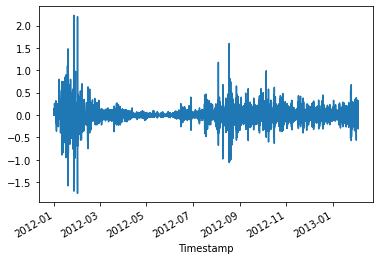

In [29]:
df["Return"] = df["Price"].diff()
df["Return"].plot()

Add `Direction` column showing if bitcoin price is going up or down.

In [33]:
df["Direction"] = pd.Series(df["Return"] > 0)
df["Direction"] = "Down"
df.loc[(df["Return"] > 0), "Direction"] = "Up"

Add `Percentage_Return` column to show the perentage return per seconds

In [37]:
df["Percentage_Return"] = ((df["Return"].shift(periods=-1))/ (df["Price"])).shift(periods=1)

Add Lag1, Lag2, Lag3, Lag4, Lag5 columns as t-1, t-2, t-3, t-4, and t-5 features to predict bitcoin price at t (in seconds)

In [39]:
df["Lag1"]= df["Percentage_Return"].shift(periods=-1)
df["Lag2"]= df["Percentage_Return"].shift(periods=-2)
df["Lag3"]= df["Percentage_Return"].shift(periods=-3)
df["Lag4"]= df["Percentage_Return"].shift(periods=-4)
df["Lag5"]= df["Percentage_Return"].shift(periods=-5)

Cleaned Dataset Display

In [40]:
df.shape

(31846, 16)

In [41]:
df.head()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Price,Return,Direction,Percentage_Return,Lag1,Lag2,Lag3,Lag4,Lag5
Timestamp,,,,,,,,,,,,,,,,
2011-12-31 07:52:00,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000,4.390,NaN,Down,NaN,0.000000,0.033030,0.009923,0.000000,0.056769
2011-12-31 15:50:00,4.39,4.39,4.39,4.39,48.000000,210.720000,4.390000,4.390,0.000,Down,0.000000,0.033030,0.009923,0.000000,0.056769,0.033058
2011-12-31 16:59:00,4.50,4.57,4.50,4.57,37.862297,171.380338,4.526411,4.535,0.145,Up,0.033030,0.009923,0.000000,0.056769,0.033058,0.000000
2011-12-31 17:00:00,4.58,4.58,4.58,4.58,9.000000,41.220000,4.580000,4.580,0.045,Up,0.009923,0.000000,0.056769,0.033058,0.000000,0.064000
2012-01-01 04:16:00,4.58,4.58,4.58,4.58,1.502000,6.879160,4.580000,4.580,0.000,Down,0.000000,0.056769,0.033058,0.000000,0.064000,-0.033835


# **LSTM Model**

LSTM stands for long short-term memory networks. It is a variety of recurrent neural network (RNN) in the deep learning field. LSTM is effective when predicting sequence of data.

#**References**

1. "Bitcoin Price Prediction with LSTM". Ansel D'souza. https://www.kaggle.com/anseldsouza/bitcoin-price-prediction-with-lstm